# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import skimage.io
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/home/masaki/software/Mask_RCNN")
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/")) 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    #IMAGE_MIN_DIM = 128
    #IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
#config.display()

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
import coco
COCO_DIR = "/home/masaki/shared_data/ohio_death/coco"  # TODO: enter value here

In [5]:
if config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "train")

    # Must call before using the dataset
    dataset.prepare()

    print("Image Count: {}".format(len(dataset.image_ids)))
    print("Class Count: {}".format(dataset.num_classes))
    for i, info in enumerate(dataset.class_info):
        print("{:3}. {:50}".format(i, info['name']), info)
    dataset_train = dataset
    dataset_val = dataset
    #for iid in dataset.image_ids:
    #    _, cids = dataset.load_mask(iid)
    #    print(iid, cids)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Image Count: 250
Class Count: 5
  0. BG                                                 {'source': '', 'id': 0, 'name': 'BG'}
  1. _background_                                       {'source': 'coco', 'id': 1, 'name': '_background_'}
  2. medcert                                            {'source': 'coco', 'id': 2, 'name': 'medcert'}
  3. cod                                                {'source': 'coco', 'id': 3, 'name': 'cod'}
  4. contrib                                            {'source': 'coco', 'id': 4, 'name': 'contrib'}


[4 3 2]


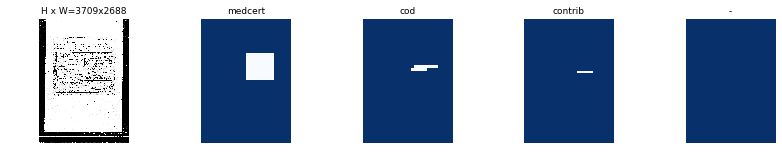

[4 3 2]


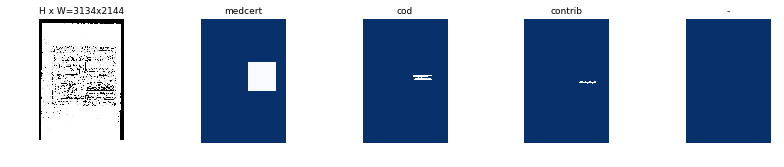

[4 3 2]


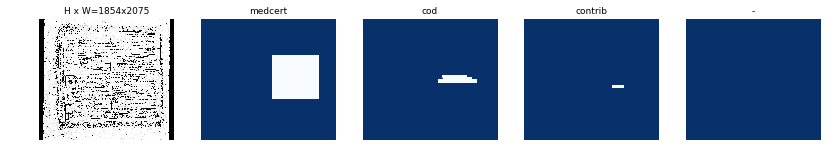

[3 2]


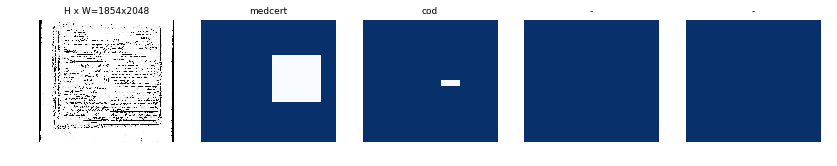

In [6]:
# Load and display random samples

image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

initialize model
building model
inputs set
other set
batch size 2 (261888, 4)
init [[-0.00552967 -0.00276484  0.00455215  0.00178732]
 [-0.00391007 -0.00391007  0.00293255  0.00293255]
 [-0.00276484 -0.00552967  0.00178732  0.00455215]
 ...
 [ 0.8499417   0.89417905  1.0259136   0.9816763 ]
 [ 0.8758553   0.8758553   1.          1.        ]
 [ 0.89417905  0.8499417   0.9816763   1.0259136 ]]
before [[[-0.00552967 -0.00276484  0.00455215  0.00178732]
  [-0.00391007 -0.00391007  0.00293255  0.00293255]
  [-0.00276484 -0.00552967  0.00178732  0.00455215]
  ...
  [ 0.8499417   0.89417905  1.0259136   0.9816763 ]
  [ 0.8758553   0.8758553   1.          1.        ]
  [ 0.89417905  0.8499417   0.9816763   1.0259136 ]]

 [[-0.00552967 -0.00276484  0.00455215  0.00178732]
  [-0.00391007 -0.00391007  0.00293255  0.00293255]
  [-0.00276484 -0.00552967  0.00178732  0.00455215]
  ...
  [ 0.8499417   0.89417905  1.0259136   0.9816763 ]
  [ 0.8758553   0.8758553   1.          1.        ]
  [ 0.894179

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/masaki/software/Mask_RCNN/logs/coco20190215T1038/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcn

/home/masaki/anaconda2/envs/py3.6/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/masaki/anaconda2/envs/py3.6/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 99/100 [============================>.] - ETA: 0s - loss: 2.9296 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.7023 - mrcnn_class_loss: 0.1420 - mrcnn_bbox_loss: 0.6104 - mrcnn_mask_loss: 0.4578

/home/masaki/anaconda2/envs/py3.6/lib/python3.6/site-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 82s 823ms/step - loss: 2.9263 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 1.7017 - mrcnn_class_loss: 0.1413 - mrcnn_bbox_loss: 0.6088 - mrcnn_mask_loss: 0.4574 - val_loss: 2.5430 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 1.4132 - val_mrcnn_class_loss: 0.1714 - val_mrcnn_bbox_loss: 0.5192 - val_mrcnn_mask_loss: 0.4276
Epoch 2/10
100/100 [==============================] - 64s 638ms/step - loss: 2.0424 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 1.2868 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.3117 - mrcnn_mask_loss: 0.3189 - val_loss: 1.7331 - val_rpn_class_loss: 0.0067 - val_rpn_bbox_loss: 1.0215 - val_mrcnn_class_loss: 0.1233 - val_mrcnn_bbox_loss: 0.2677 - val_mrcnn_mask_loss: 0.3139
Epoch 3/10
100/100 [==============================] - 65s 654ms/step - loss: 1.7361 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 1.0885 - mrcnn_class_loss: 0.1142 - mrcnn_bbox_loss: 0.2558 - mrcnn_mask_loss: 0.2717 - val_loss: 1.7370 - val_rpn_class_loss: 

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all")


Starting at epoch 10. LR=0.0001

Checkpoint Path: /home/masaki/software/Mask_RCNN/logs/coco20190215T1038/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn

In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

initialize model
building model
inputs set
other set
anchors
rpn
[<tf.Tensor 'ROI_1/strided_slice:0' shape=(?, ?) dtype=float32>, <tf.Tensor 'ROI_1/top_anchors:1' shape=(?, ?) dtype=int32>]
2
[<tf.Tensor 'ROI_1/mul:0' shape=(?, ?, 4) dtype=float32>, <tf.Tensor 'ROI_1/top_anchors:1' shape=(?, ?) dtype=int32>]
2
[<tf.Tensor 'input_anchors:0' shape=(?, ?, 4) dtype=float32>, <tf.Tensor 'ROI_1/top_anchors:1' shape=(?, ?) dtype=int32>]
2
[<tf.Tensor 'ROI_1/pre_nms_anchors:0' shape=(1, ?, 4) dtype=float32>, <tf.Tensor 'ROI_1/packed_1:0' shape=(1, ?, 4) dtype=float32>]
2
[<tf.Tensor 'ROI_1/refined_anchors:0' shape=(1, ?, 4) dtype=float32>]
1
[<tf.Tensor 'ROI_1/refined_anchors_clipped:0' shape=(1, ?, 4) dtype=float32>, <tf.Tensor 'ROI_1/packed:0' shape=(1, ?) dtype=float32>]
2
roi
[<tf.Tensor 'ROI_1/packed_2:0' shape=(1, ?, 4) dtype=float32>, <tf.Tensor 'mrcnn_class_1/Reshape_1:0' shape=(?, 1000, 5) dtype=float32>, <tf.Tensor 'mrcnn_bbox_1/Reshape:0' shape=(?, 1000, 5, 4) dtype=float32>, <tf.Te

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 3197.00000  float64
gt_class_id              shape: (3,)                  min:    2.00000  max:    4.00000  int32
gt_bbox                  shape: (3, 4)                min:  290.00000  max:  757.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool


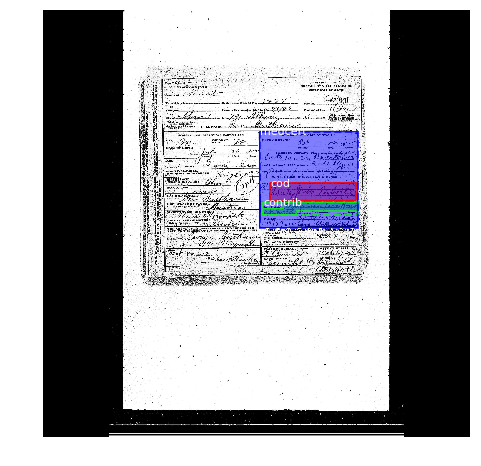

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


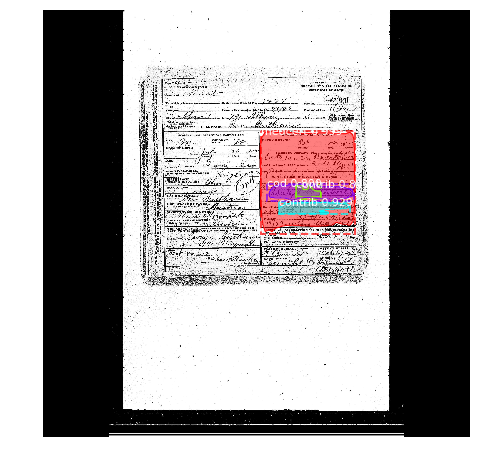

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())


## Evaluation

In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8194444494942823


In [28]:
# Load a random image from the images folder
IMAGE_DIR = '/home/masaki/shared_data/ohio_death/from_umichigan'
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
if image.ndim != 3:
    image = skimage.color.gray2rgb(image)
if image.shape[-1] == 4:
    image = image[..., :3]

Processing 1 images
image                    shape: (3102, 2112, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 3102.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


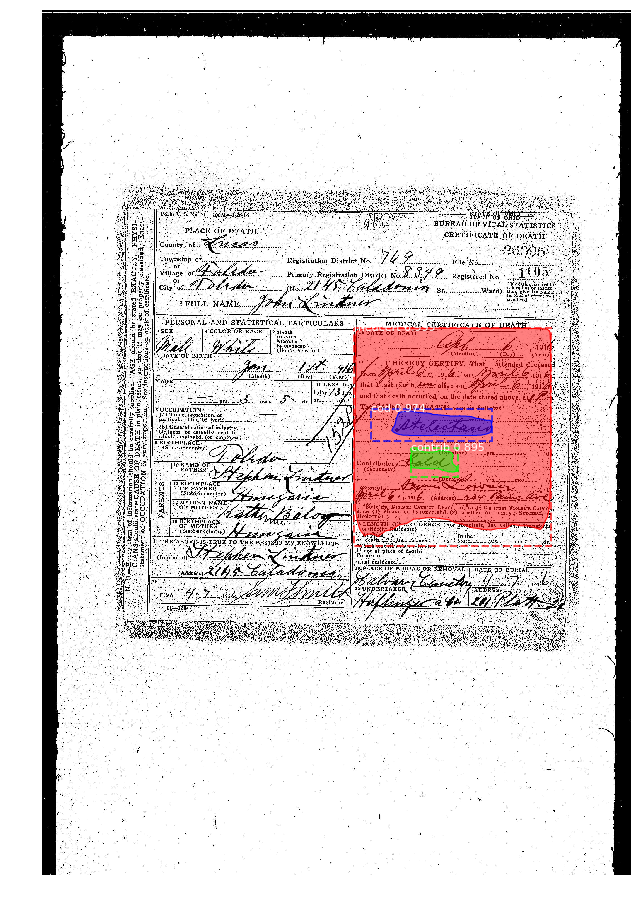

In [29]:
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

In [27]:
print(image.shape)
print(original_image.shape)

(1854, 2048, 3)
(1024, 1024, 3)
